In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import sys


cudnn.benchmark = True
plt.ion()   # interactive mode

In [8]:
from dataset import ELPVImageDataset
from torch.utils.data import random_split, DataLoader

"""
To prepare the data to training, we split the original dataset of 2624 images into two sets, one for training and one for testing
The ratio of training samples to testing samples here is 70% training, 15% validation, 15% testing
"""

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

        v2.RandomAffine(degrees=(-3, 3), translate=(0, 0.02), scale=(1.0, 1.02)),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),

    ]),
    'val': v2.Compose([
        v2.Resize(size=(224, 224)),
        transforms.ToTensor(),
    ]),
}

fullDataset = ELPVImageDataset('./labels.csv', 'elpv', transform=data_transforms['train'])

seed = torch.Generator().manual_seed(42)
trainData, valData, testData = random_split(fullDataset, [0.70, 0.15, 0.15], generator=seed)

trainDataloader = DataLoader(trainData, batch_size=32, shuffle=True)
valDataLoader = DataLoader(valData, batch_size=32, shuffle=True)
testDataloader = DataLoader(testData, batch_size=32, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train Data: {len(trainData)} samples")
print(f"Validation Data: {len(valData)} samples")
print(f"Test Data: {len(testData)} samples")

Train Data: 1837 samples
Validation Data: 394 samples
Test Data: 393 samples


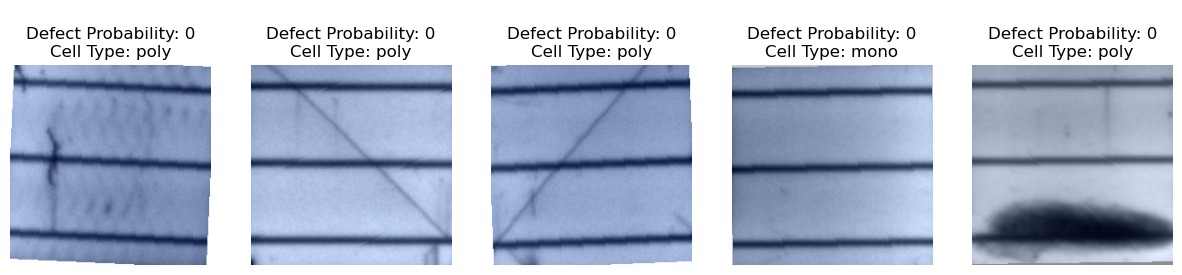

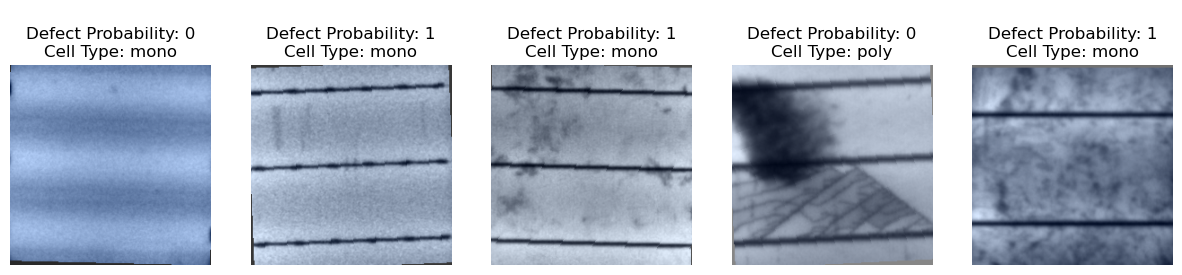

In [3]:

import matplotlib.pyplot as plt

"""
Select a few images to visualize the dataset images, as well as the transforms
"""

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Get image, label, cell type
        image, label, cellType = dataset[i]
        cellType = "mono" if cellType == 0 else "poly"

        # Convert image tensor to numpy array for display
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Display the image
        axes[i].imshow(image_np)
        axes[i].axis('off')
        axes[i].set_title(f'\nDefect Probability: {label}\nCell Type: {cellType}')

    plt.show()

show_images(fullDataset) 
show_images(trainData) 

In [4]:
import torch
import torch.nn as nn

"""
Setup our model, criterion, and parameters
Currently using a modified pre-trained resnet18 to take advantage of transfer learning
"""

def closest_probability_class(value):
    probabilities = torch.Tensor([0, 1/3, 2/3, 1])
    return min(probabilities, key=lambda x: abs(x - value))

class ModifiedResNet(nn.Module):
    """
    This is a modified resnet model in which the final fully connected layer is modified to output
    a single scalar value (the predicted probability of defect).

    In addition, the features going into the final fully connected layer is modified. Namely, we concatenate
    the solar cell type (0 for 'mono', 1 for 'poly') to the feature vector going into the fc player.
    """
    def __init__(self, resnetModel):
        super(ModifiedResNet, self).__init__()
        # Everything except the last linear layer
        self.features = nn.Sequential(*list(resnetModel.children())[:-1])
        
        # freeze all the parameters up until the last FC layer, since we want to use
        # the pre-trained network as a feature-extractor
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Get the number of features going into the last fc layer
        num_ftrs = resnetModel.fc.in_features

        # Redefine the last linear layer / fully connected layer
        # Since we are doing regression, the final output is a scalar value
        self.fc = nn.Linear(num_ftrs + 1, 1)
        nn.init.xavier_uniform_(self.fc.weight) # initalize random  weights for the fc layer

    def forward(self, image, cellType):
        """
        In addition to the original features being passed into the fully connected layer,
        we also concatenate the solar panel cell type (0 for mono, 1 for poly) to the feature vector
        
        image: 
            The torch tensor image
        
        cellType:
            0 dimensional tensor, where the value is 0 for mono, 1 for poly
        """

        x = self.features(image)
        x = torch.flatten(x, 1)

        # Concatenate the additional features
        x = torch.cat((x, cellType), dim=1)

        # Pass through the modified fully connected layer
        x = self.fc(x)
        
        # Round the predicted probability output to the nearest probability class (0, 0.33, 0.66, 1)
        # x = x.apply_(closest_probability_class)

        return x.double()

model_ft = ModifiedResNet(models.resnet18(weights='IMAGENET1K_V1'))

model_ft = model_ft.to(device)

# Since we're doing regression instead of classification, we use MSE instead of Cross Entropy
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

In [5]:
def train_model(model, dataset_sizes, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for images, cell_types, labels in dataloaders[phase]:
                # cell_types is of shape [N], where N is the batch size
                # we need to convert this to shape [N, 1] in order to make it easier to 
                # concatenate the cell_type with the feature vector in the resnet model
                cell_types = cell_types.unsqueeze(1)

                # move all data to training device
                images = images.to(device)
                cell_types = cell_types.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, cell_types)
                    outputs = outputs.squeeze() # make sure output tensor is same shape as labels

                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(dim=0) # TODO: do I need this images.size()?

                """
                To compute accuracy, we round the predicted probability to the nearest neighbor within
                [0.0, 0.33333, 0.66666, 1.0], then compare the value to the truth label
                """
                
                # unfortunately we cannot apply a function over a gpu tensor (it's not supported by pytorch)
                # so we'll need to manually create a new tensor with the rounding applied.
                
                predictions = torch.Tensor([closest_probability_class(pred) for pred in outputs]).double()
                corrects = torch.Tensor([1 if torch.allclose(predictions[i], labels[i]) else 0 for i in range(len(predictions))]) # torch.allclose(a, b) evaluates to true if a and b are approximately equal
                running_corrects += torch.sum(corrects)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')
            print(f'{phase} Acc: {epoch_acc:.4f}')
    
    return model


In [6]:
"""
Train our model
"""

dataloaders = {
    'train': trainDataloader,
    'val': valDataLoader,
    'test': testDataloader,
}

image_datasets = {
    'train': trainData,
    'val': valData,
    'test': testData,
}

dataset_sizes = {
    'train': len(trainData),
    'val': len(valData),
    'test': len(testData),
}

model_ft = train_model(
    model_ft,
    dataset_sizes,
    dataloaders,
    criterion=nn.MSELoss(),
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    num_epochs=100,
)

Epoch 1/100
----------
train Loss: 0.8037
train Acc: 0.3723
val Loss: 0.5837
val Acc: 0.3680
Epoch 2/100
----------
train Loss: 0.5204
train Acc: 0.3615
val Loss: 0.4583
val Acc: 0.4061
Epoch 3/100
----------
train Loss: 0.3798
train Acc: 0.3887
val Loss: 0.4095
val Acc: 0.4518
Epoch 4/100
----------
train Loss: 0.3226
train Acc: 0.3914
val Loss: 0.3205
val Acc: 0.3655
Epoch 5/100
----------
train Loss: 0.3022
train Acc: 0.3903
val Loss: 0.3306
val Acc: 0.3629
Epoch 6/100
----------
train Loss: 0.2566
train Acc: 0.4050
val Loss: 0.2447
val Acc: 0.4137
Epoch 7/100
----------
train Loss: 0.2328
train Acc: 0.3919
val Loss: 0.2668
val Acc: 0.4340
Epoch 8/100
----------
train Loss: 0.2245
train Acc: 0.3876
val Loss: 0.2371
val Acc: 0.3198
Epoch 9/100
----------
train Loss: 0.2023
train Acc: 0.3805
val Loss: 0.1985
val Acc: 0.4391
Epoch 10/100
----------
train Loss: 0.1904
train Acc: 0.3979
val Loss: 0.1892
val Acc: 0.4569
Epoch 11/100
----------
train Loss: 0.1918
train Acc: 0.4132
val Loss